In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series

import numpy as np
import matplotlib.pyplot as plt

### 设置路径

In [2]:
path_pre = '../../'
path_original_dataset = path_pre + 'original-dataset/'
path_intermediate_dataset = path_pre + 'intermediate-dataset/'

### 加载 train.h5

In [3]:
train_df = pd.read_hdf(path_intermediate_dataset + 'train.h5')
train_df.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator
3608772,0,301730,NaN,4565,1,1803,2,1.0
2362282,0,261335,NaN,4121,2,1842,1,2.0
415865,0,181549,NaN,274,4,3322,1,2.0
2139782,0,251726,NaN,3362,5,7434,1,1.0
2301428,0,260931,NaN,1858,5,7434,1,1.0


### 从`userID`中提取`conversion_count`特征

In [4]:
userID_count_positive = train_df.loc[train_df['label'] == 1, 'userID'].value_counts()
userID_count_positive.sort_index(inplace=True)
userID_count_positive.value_counts().sort_index()

1     90975
2       973
3        88
4         9
5         1
6         3
7         1
11        1
Name: userID, dtype: int64

In [5]:
userID_count_positive_df = DataFrame(userID_count_positive)
userID_count_positive_df.reset_index(inplace=True)
userID_count_positive_df.columns = ['userID', 'conversion_count']
userID_count_positive_df.head()

,userID,conversion_count
0,22,1
1,33,1
2,66,1
3,68,1
4,113,1


In [11]:
userID_count_positive_df.index.size

92051

### 对`userID`提取`click_count_group`特征

In [6]:
userID_count = train_df['userID'].value_counts()
userID_count.sort_index(inplace=True)
userID_count.head()

1     1
2     1
4     1
5    10
6     2
Name: userID, dtype: int64

In [7]:
userID_count_df = DataFrame(userID_count)
userID_count_df.reset_index(inplace=True)
userID_count_df.columns = ['userID', 'click_count']
userID_count_df.head()

,userID,click_count
0,1,1
1,2,1
2,4,1
3,5,10
4,6,2


0: [1, 28]    
1: (28, 44]   
2: (44, 120]  

In [8]:
# 对 click_count 分组
bins = [1, 28, 44, 120]
userID_count_df['click_count_group'] = pd.cut(userID_count_df['click_count'], bins=bins, include_lowest=True, labels=False)
userID_count_df.head()

,userID,click_count,click_count_group
0,1,1,0
1,2,1,0
2,4,1,0
3,5,10,0
4,6,2,0


In [9]:
userID_count_df['click_count_group'].value_counts()

0    2595363
1        224
2         40
Name: click_count_group, dtype: int64

In [10]:
userID_count_df.index.size

2595627

In [15]:
# 合并
f_userID = userID_count_df.merge(userID_count_positive_df, how='left', on='userID')
f_userID.head()

,userID,click_count,click_count_group,conversion_count
0,1,1,0,NaN
1,2,1,0,NaN
2,4,1,0,NaN
3,5,10,0,NaN
4,6,2,0,NaN


In [16]:
# 将缺失值填充为0
f_userID['conversion_count'].fillna(value=0, inplace=True)
f_userID.head()

,userID,click_count,click_count_group,conversion_count
0,1,1,0,0.0
1,2,1,0,0.0
2,4,1,0,0.0
3,5,10,0,0.0
4,6,2,0,0.0


In [17]:
f_userID.index.size

2595627

### 对`userID`提取`conversion_ratio`特征

In [18]:
f_userID['conversion_ratio_click'] = f_userID['conversion_count'] / f_userID['click_count']
f_userID.head()

,userID,click_count,click_count_group,conversion_count,conversion_ratio_click
0,1,1,0,0.0,0.0
1,2,1,0,0.0,0.0
2,4,1,0,0.0,0.0
3,5,10,0,0.0,0.0
4,6,2,0,0.0,0.0


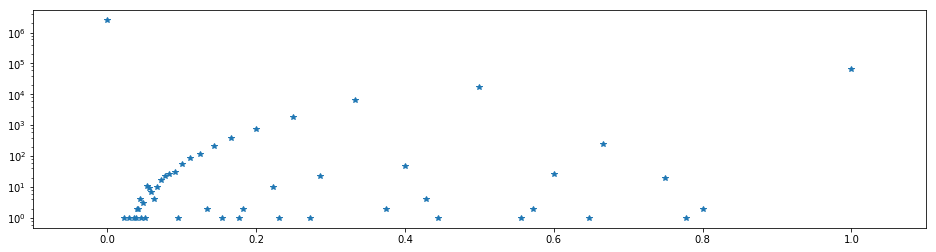

In [19]:
distribution = f_userID['conversion_ratio_click'].value_counts().sort_index()
distribution.plot(figsize=(16,4), style='*', logy=True)
plt.xlim([-0.1, 1.1])
plt.show()

这个的纵坐标是`样本数`，与之前数据分析中的图不一样，那个是用户数

In [20]:
distribution.index.size

51

不算太多，还是可以做one-hot的

### 存储

In [21]:
del f_userID['click_count']
f_userID.head()

,userID,click_count_group,conversion_count,conversion_ratio_click
0,1,0,0.0,0.0
1,2,0,0.0,0.0
2,4,0,0.0,0.0
3,5,0,0.0,0.0
4,6,0,0.0,0.0
